In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2022-10-03 21:12:23--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.02s   

2022-10-03 21:12:24 (3.56 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [3]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [4]:
df['card'] = df.card.map(lambda x : 1 if x=='yes' else 0)

In [5]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
int_cols = ['reports','age','income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

scores = {}

for columns in int_cols:
    score = roc_auc_score(df_train['card'], df_train[columns])
    if score < 0.5:
        score = roc_auc_score(df_train['card'], -df_train[columns])
    scores[columns] = score

print(scores)

{'reports': 0.7166629860689376, 'age': 0.5240020979407055, 'income': 0.5908049467233478, 'share': 0.989183643423692, 'expenditure': 0.991042345276873, 'dependents': 0.5327757227773791, 'months': 0.5294217780967629, 'majorcards': 0.5343859842838476, 'active': 0.6043173411362006}


In [7]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

def encoder(data):

    dv = DictVectorizer(sparse=False)
    dictd = data[features].to_dict(orient='records')
    data_transformed = dv.fit_transform(dictd)

    return data_transformed

X_train = encoder(df_train)
y_train = df_train.card.values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

X_val = encoder(df_val)
y_val = df_val.card.values

y_preds = model.predict_proba(X_val)[:, 1]

In [8]:
auc = roc_auc_score(y_val, (y_preds>=0.5).astype(int))
print("%.3f" %(auc))

0.974


In [9]:
act_positive = (y_val == 1)
act_negative = (y_val == 0)

thresholds = np.arange(0.0, 1.0, 0.01)
precisions, recalls = [], []
f1 = []

for val in thresholds:
    y_pred = (y_preds >= val).astype(int)

    pred_positive = (y_pred == 1)
    pred_negative = (y_pred == 0)

    tp = (act_positive & pred_positive).sum()
    tn = (act_negative & pred_negative).sum()

    fp = (act_negative & pred_positive).sum()
    fn = (act_positive & pred_negative).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    precisions.append(p)
    recalls.append(r)
    score = (2 * p * r) / (p + r)
    f1.append(score)

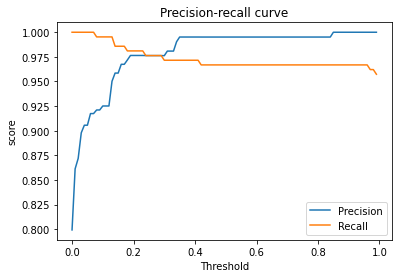

In [10]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

plt.xlabel("Threshold")
plt.ylabel("score")
plt.title("Precision-recall curve")

plt.legend()
plt.show()

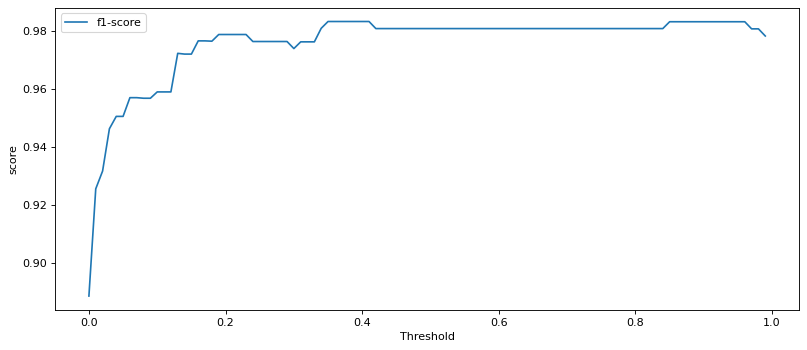

In [11]:
plt.figure(figsize=(12, 5), dpi=80)
plt.plot(thresholds, f1, label='f1-score')

plt.xlabel("Threshold")
plt.ylabel("score")

plt.legend()
plt.show()

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for tr_idx, val_idx in kfold.split(df_full_train):

    df_train = df_full_train.iloc[tr_idx]
    df_val = df_full_train.iloc[val_idx]

    X_train = encoder(df_train)
    y_train = df_train.card.values 

    X_val = encoder(df_val)
    y_val = df_val.card.values 

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_val)

    auc = roc_auc_score(y_val, y_preds) 
    scores.append(auc)

print("Mean: %f, STD: %f" %(np.mean(scores), np.std(scores)))

Mean: 0.983349, STD: 0.011596


In [13]:
c = {}

for C in [0.01, 0.1, 1, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for tr_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[tr_idx]
        df_val = df_full_train.iloc[val_idx]

        X_train = encoder(df_train)
        y_train = df_train.card.values 

        X_val = encoder(df_val)
        y_val = df_val.card.values 

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_preds = model.predict(X_val)

        auc = roc_auc_score(y_val, y_preds) 
        scores.append(auc)

    c[C] = round(np.mean(scores)), round(np.std(scores), 3)
    
sc_df = pd.DataFrame(data=c.values(), index=c.keys(), columns=['mean', 'std'])
sc_df

,mean,std
0.01,1,0.007
0.10,1,0.010
1.00,1,0.012
10.00,1,0.014
